In [2]:
%pip install tensorflow_io==0.31.0

In [1]:
%pip install tensorflow==2.11.0

In [3]:
%pip install tensorflow_hub

In [4]:
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
esc50_csv = '/content/drive/MyDrive/ESC-50-master/meta/esc50.csv'
base_data_path = '/content/drive/MyDrive/ESC-50-master/audio/'

pd_data = pd.read_csv(esc50_csv)
pd_data.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [7]:
my_classes = ['dog', 'cat']
map_class_to_id = {'dog':0, 'cat':1}

filtered_pd = pd_data[pd_data.category.isin(my_classes)]

class_id = filtered_pd['category'].apply(lambda name: map_class_to_id[name])
filtered_pd = filtered_pd.assign(target=class_id)

full_path = filtered_pd['filename'].apply(lambda row: os.path.join(base_data_path, row))
filtered_pd = filtered_pd.assign(filename=full_path)

filtered_pd.head(10)

,filename,fold,target,category,esc10,src_file,take
0,/content/drive/MyDrive/ESC-50-master/audio/1-1...,1,0,dog,True,100032,A
14,/content/drive/MyDrive/ESC-50-master/audio/1-1...,1,0,dog,True,110389,A
157,/content/drive/MyDrive/ESC-50-master/audio/1-3...,1,0,dog,True,30226,A
158,/content/drive/MyDrive/ESC-50-master/audio/1-3...,1,0,dog,True,30344,A
170,/content/drive/MyDrive/ESC-50-master/audio/1-3...,1,0,dog,True,32318,A
175,/content/drive/MyDrive/ESC-50-master/audio/1-3...,1,1,cat,False,34094,A
176,/content/drive/MyDrive/ESC-50-master/audio/1-3...,1,1,cat,False,34094,B
229,/content/drive/MyDrive/ESC-50-master/audio/1-4...,1,1,cat,False,47819,A
230,/content/drive/MyDrive/ESC-50-master/audio/1-4...,1,1,cat,False,47819,B
231,/content/drive/MyDrive/ESC-50-master/audio/1-4...,1,1,cat,False,47819,C


In [8]:
filenames = filtered_pd['filename']
targets = filtered_pd['target']
folds = filtered_pd['fold']

main_ds = tf.data.Dataset.from_tensor_slices((filenames, targets, folds))
main_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [9]:
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

In [10]:
# Служебные функции для загрузки аудиофайлов и проверки правильности частоты дискретизации.

@tf.function
def load_wav_16k_mono(filename):
    """ Загрузите WAV-файл, преобразуйте его в тензор с плавающей запятой, повторите дискретизацию до одноканального звука частотой 16 кГц. """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [11]:
def load_wav_for_map(filename, label, fold):
  return load_wav_16k_mono(filename), label, fold

main_ds = main_ds.map(load_wav_for_map)
main_ds.element_spec

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [12]:
# applies the embedding extraction model to a wav data
def extract_embedding(wav_data, label, fold):
  ''' run YAMNet to extract embedding from the wav data '''
  scores, embeddings, spectrogram = yamnet_model(wav_data)
  num_embeddings = tf.shape(embeddings)[0]
  return (embeddings,
            tf.repeat(label, num_embeddings),
            tf.repeat(fold, num_embeddings))

# extract embedding
main_ds = main_ds.map(extract_embedding).unbatch()
main_ds.element_spec

(TensorSpec(shape=(1024,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [13]:
cached_ds = main_ds.cache()
train_ds = cached_ds.filter(lambda embedding, label, fold: fold < 4)
val_ds = cached_ds.filter(lambda embedding, label, fold: fold == 4)
test_ds = cached_ds.filter(lambda embedding, label, fold: fold == 5)

# remove the folds column now that it's not needed anymore
remove_fold_column = lambda embedding, label, fold: (embedding, label)

train_ds = train_ds.map(remove_fold_column)
val_ds = val_ds.map(remove_fold_column)
test_ds = test_ds.map(remove_fold_column)

train_ds = train_ds.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)

In [14]:
my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(len(my_classes))
], name='my_model')

my_model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               524800    
                                                                 
 dense_1 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 525,826
Trainable params: 525,826
Non-trainable params: 0
_________________________________________________________________


In [15]:
my_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer="adam",
                 metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=3,
                                            restore_best_weights=True)

In [16]:
history = my_model.fit(train_ds,
                       epochs=20,
                       validation_data=val_ds,
                       callbacks=callback)

Epoch 1/20
15/15 [==============================] - 26s 83ms/step - loss: 0.7119 - accuracy: 0.7917 - val_loss: 0.4855 - val_accuracy: 0.9000
Epoch 2/20
15/15 [==============================] - 0s 8ms/step - loss: 0.4809 - accuracy: 0.8917 - val_loss: 1.1211 - val_accuracy: 0.8687
Epoch 3/20
15/15 [==============================] - 0s 8ms/step - loss: 0.7274 - accuracy: 0.8833 - val_loss: 0.6170 - val_accuracy: 0.8687
Epoch 4/20
15/15 [==============================] - 0s 7ms/step - loss: 0.3468 - accuracy: 0.9042 - val_loss: 0.2156 - val_accuracy: 0.9187
Epoch 5/20
15/15 [==============================] - 0s 8ms/step - loss: 0.1848 - accuracy: 0.9146 - val_loss: 0.2286 - val_accuracy: 0.8813
Epoch 6/20
15/15 [==============================] - 0s 7ms/step - loss: 0.1684 - accuracy: 0.9125 - val_loss: 0.2703 - val_accuracy: 0.8813
Epoch 7/20
15/15 [==============================] - 0s 7ms/step - loss: 0.1852 - accuracy: 0.9333 - val_loss: 0.2742 - val_accuracy: 0.9125
Epoch 8/20
15/15 [

In [17]:
loss, accuracy = my_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

5/5 [==============================] - 0s 9ms/step - loss: 0.3695 - accuracy: 0.8125
Loss:  0.3695322275161743
Accuracy:  0.8125


In [18]:
testing_wav_file_name = tf.keras.utils.get_file('miaow_16k.wav',
                                                'https://storage.googleapis.com/audioset/miaow_16k.wav',
                                                cache_dir='./',
                                                cache_subdir='test_data')

print(testing_wav_file_name)

215546/215546 [==============================] - 0s 0us/step
./test_data/miaow_16k.wav


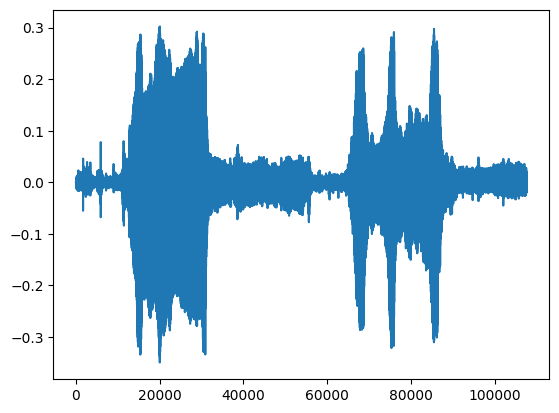

In [19]:
testing_wav_data = load_wav_16k_mono(testing_wav_file_name)

_ = plt.plot(testing_wav_data)

# Play the audio file.
display.Audio(testing_wav_data,rate=16000)

In [ ]:
scores, embeddings, spectrogram = yamnet_model(testing_wav_data)
result = my_model(embeddings).numpy()

inferred_class = my_classes[result.mean(axis=0).argmax()]
print(f'The main sound is: {inferred_class}')

The main sound is: dog


In [20]:
testing_wav_file_name = "/content/drive/MyDrive/lay-sobaki.wav"

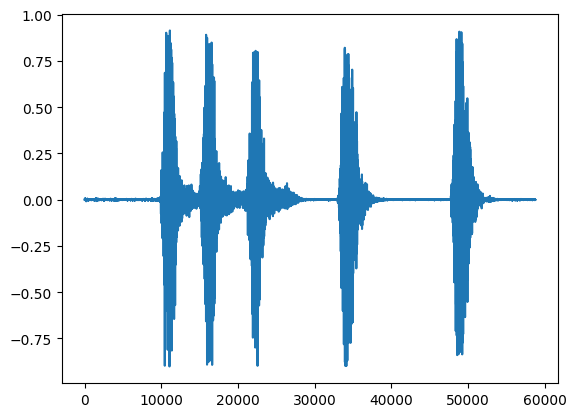

In [21]:
testing_wav_data = load_wav_16k_mono(testing_wav_file_name)

_ = plt.plot(testing_wav_data)

# Play the audio file.
display.Audio(testing_wav_data,rate=16000)

In [22]:
scores, embeddings, spectrogram = yamnet_model(testing_wav_data)
result = my_model(embeddings).numpy()

inferred_class = my_classes[result.mean(axis=0).argmax()]
print(f'The main sound is: {inferred_class}')

The main sound is: dog
